# RNN - Recurrent Neural Network

# UrbanSound8K Audio Classification with RNN (BiGRU)

In this notebook, we train a Recurrent Neural Network (RNN) to classify audio samples from the UrbanSound8K dataset, using MFCC features previously generated by the script `preprocess_urbansound.py`.

RNNs are designed to process sequential data, such as audio, text, or time-series, because they keep an internal representation of past time steps.

Here we use a **Bidirectional Gated Recurrent Unit (BiGRU)**:
- A **GRU** is an efficient type of recurrent layer that captures temporal dependencies.
- **Bidirectional** means the sequence is processed both forward and backward, improving context awareness.
- MFCCs are treated as a time-series of audio frames, making them suitable for RNNs.

This notebook performs **10-fold cross-validation**:
- one model is trained per fold,
- learning curves (accuracy and loss) are generated per fold,
- a confusion matrix is plotted per fold,
- test accuracy and loss are summarised across folds,
- an accumulated confusion matrix over all folds is generated.

The goal is to evaluate how well a BiGRU model can recognise different urban sounds.

#### Imports

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from preprocess_urbansound import load_fold, load_metadata

## Build the BiGRU model

This function defines the architecture of the recurrent neural network:
- a bidirectional GRU layer (210 units per direction),
- dropout layers to reduce overfitting,
- a dense hidden layer,
- a softmax output layer for multi-class classification.

The model processes MFCC sequences as time-series:
`(time_steps = 173, features = 40)`.

In [2]:
def build_rnn_model(time_steps=173, n_features=40, n_classes=10):
    """
    RNN Model:
    - Bidirectional GRU with 210 units per direction
    - Dropout for regularisation
    - Dense intermediate layer + softmax output
    """
    model = models.Sequential([
        layers.Input(shape=(time_steps, n_features)),

        layers.Bidirectional(
            layers.GRU(210, return_sequences=False)
        ),
        layers.Dropout(0.4),

        layers.Dense(80, activation='relu'),
        layers.Dropout(0.4),

        layers.Dense(n_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## Load MFCC data for a single fold

MFCCs were pre-processed with shape `(N, 40, 173)`
(features × time frames).

RNNs expect `(time_steps, features)`, so we transpose inputs into:
`(N, 173, 40)`.

In [3]:
def load_rnn_data_for_fold(fold_num, feature_type="mfcc"):
    """
    Loads X_train, y_train, X_val, y_val, X_test, y_test
    and converts arrays to the RNN-compatible format:
        (N, time_steps, n_features)
    """

    X_train, y_train, X_val, y_val, X_test, y_test = load_fold(fold_num, feature_type)

    # Transpose from (N, 40, 173) → (N, 173, 40)
    X_train = np.transpose(X_train, (0, 2, 1))
    X_val   = np.transpose(X_val, (0, 2, 1))
    X_test  = np.transpose(X_test, (0, 2, 1))

    return X_train, y_train, X_val, y_val, X_test, y_test

## Train and evaluate a single fold

This function:
- builds a BiGRU model,
- trains it using early stopping (based on validation loss),
- evaluates the model on the test split,
- generates:
  - learning curves (train/validation accuracy and loss),
  - a confusion matrix for that fold.

It returns the test loss, test accuracy, confusion matrix, and training history.

In [4]:
def train_one_fold(
    fold_num,
    time_steps=173,
    n_features=40,
    n_classes=10,
    batch_size=32,
    epochs=25,
    class_labels=None
):
    print(f"\n{'='*70}")
    print(f"Training fold {fold_num}/10")
    print(f"{'='*70}")

    # Load fold data
    X_train, y_train, X_val, y_val, X_test, y_test = load_rnn_data_for_fold(
        fold_num, "mfcc"
    )

    print(f"  X_train shape: {X_train.shape}")
    print(f"  X_val   shape: {X_val.shape}")
    print(f"  X_test  shape: {X_test.shape}")

    # Build model
    model = build_rnn_model(time_steps=time_steps,
                            n_features=n_features,
                            n_classes=n_classes)
    model.summary()

    # Early stopping
    es = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # ---------- TRAIN ----------
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=2
    )

    # ---------- TEST ----------
    test_probs = model.predict(X_test, verbose=0)
    test_preds = np.argmax(test_probs, axis=1)

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print(f"\nTest accuracy (fold {fold_num}): {test_acc:.4f}")
    print(f"Test loss     (fold {fold_num}): {test_loss:.4f}")

    cm = confusion_matrix(y_test, test_preds)

    # ---------- PLOTS FOR THIS FOLD ----------
    epochs_range = range(1, len(history.history['loss']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy
    axes[0].plot(epochs_range, history.history['accuracy'], label='Train')
    axes[0].plot(epochs_range, history.history['val_accuracy'], label='Validation')
    axes[0].set_title(f'Model Accuracy – Fold {fold_num}')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)

    # Loss
    axes[1].plot(epochs_range, history.history['loss'], label='Train')
    axes[1].plot(epochs_range, history.history['val_loss'], label='Validation')
    axes[1].set_title(f'Model Loss – Fold {fold_num}')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    display_labels = class_labels if class_labels else np.arange(n_classes)

    fig, ax = plt.subplots(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)
    disp.plot(ax=ax, cmap='Blues', colorbar=True)
    plt.title(f'Confusion Matrix – Fold {fold_num}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return test_loss, test_acc, cm, history.history

## Run full 10-fold cross-validation

This section:
- runs `train_one_fold` for all 10 folds,
- stores test loss and accuracy per fold,
- accumulates the confusion matrix across folds,
- prints detailed per-fold results,
- computes mean and standard deviation of test metrics,
- plots:
  - accumulated confusion matrix,
  - test accuracy per fold,
  - test loss per fold.

In [5]:
def run_cross_validation():
    metadata = load_metadata()
    n_classes = metadata.get('num_classes', 10)
    print("Classes:", metadata.get('class_to_idx', {}))
    print("Number of classes:", n_classes)

    class_to_idx = metadata.get('class_to_idx', {})
    if class_to_idx:
        idx_to_class = {idx: name for name, idx in class_to_idx.items()}
        class_labels = [idx_to_class[i] for i in range(n_classes)]
    else:
        class_labels = [str(i) for i in range(n_classes)]

    time_steps = 173
    n_features = 40

    all_test_accs = []
    all_test_losses = []
    global_conf_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    all_histories = []

    for fold in range(1, 11):
        test_loss, test_acc, cm, history = train_one_fold(
            fold_num=fold,
            time_steps=time_steps,
            n_features=n_features,
            n_classes=n_classes,
            batch_size=32,
            epochs=25,
            class_labels=class_labels
        )
        all_test_accs.append(test_acc)
        all_test_losses.append(test_loss)
        global_conf_matrix += cm
        all_histories.append(history)

    # ---------- NUMERIC SUMMARY ----------
    print("\n\nPer-fold test metrics (accuracy & loss):")
    for i, (acc, loss) in enumerate(zip(all_test_accs, all_test_losses), start=1):
        print(f"Fold {i:2d} -> test_acc = {acc:.4f} | test_loss = {loss:.4f}")

    print("\nFinal 10-Fold Results (BiGRU)")
    print("-----------------------------")
    print(f"Mean test accuracy: {np.mean(all_test_accs):.4f}")
    print(f"Std  test accuracy: {np.std(all_test_accs):.4f}")
    print(f"Mean test loss:     {np.mean(all_test_losses):.4f}")
    print(f"Std  test loss:     {np.std(all_test_losses):.4f}")

    print("\nAccumulated Confusion Matrix (10 folds):")
    print(global_conf_matrix)

    # ---------- ACCUMULATED CONFUSION MATRIX ----------
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=global_conf_matrix,
                                  display_labels=class_labels)
    disp.plot(ax=ax, cmap='Blues', colorbar=True)
    plt.title("Accumulated Confusion Matrix (10 folds)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ---------- TEST ACCURACY PER FOLD ----------
    folds = np.arange(1, 11)

    plt.figure(figsize=(7, 4))
    plt.plot(folds, all_test_accs, marker='o')
    plt.title("Test Accuracy per Fold")
    plt.xlabel("Fold")
    plt.ylabel("Test Accuracy")
    plt.grid(True)
    plt.xticks(folds)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # ---------- TEST LOSS PER FOLD ----------
    plt.figure(figsize=(7, 4))
    plt.plot(folds, all_test_losses, marker='o')
    plt.title("Test Loss per Fold")
    plt.xlabel("Fold")
    plt.ylabel("Test Loss")
    plt.grid(True)
    plt.xticks(folds)
    plt.tight_layout()
    plt.show()

## Run the full pipeline

Set random seeds for reproducibility and execute the full 10-fold cross-validation.

Classes: {'air_conditioner': 0, 'car_horn': 1, 'children_playing': 2, 'dog_bark': 3, 'drilling': 4, 'engine_idling': 5, 'gun_shot': 6, 'jackhammer': 7, 'siren': 8, 'street_music': 9}
Number of classes: 10

Training fold 1/10
  X_train shape: (6971, 173, 40)
  X_val   shape: (888, 173, 40)
  X_test  shape: (873, 173, 40)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
218/218 - 23s - 106ms/step - accuracy: 0.3367 - loss: 1.8972 - val_accuracy: 0.4155 - val_loss: 1.5542
Epoch 2/25
218/218 - 19s - 89ms/step - accuracy: 0.4886 - loss: 1.4666 - val_accuracy: 0.4516 - val_loss: 1.3798
Epoch 3/25
218/218 - 19s - 88ms/step - accuracy: 0.5722 - loss: 1.2422 - val_accuracy: 0.4955 - val_loss: 1.3004
Epoch 4/25
218/218 - 20s - 91ms/step - accuracy: 0.6153 - loss: 1.1250 - val_accuracy: 0.4786 - val_loss: 1.2956
Epoch 5/25
218/218 - 20s - 92ms/step - accuracy: 0.6583 - loss: 1.0066 - val_accuracy: 0.5327 - val_loss: 1.2167
Epoch 6/25
218/218 - 19s - 87ms/step - accuracy: 0.6861 - loss: 0.9189 - val_accuracy: 0.5113 - val_loss: 1.3455
Epoch 7/25
218/218 - 19s - 89ms/step - accuracy: 0.7221 - loss: 0.8149 - val_accuracy: 0.5417 - val_loss: 1.3337
Epoch 8/25
218/218 - 20s - 91ms/step - accuracy: 0.7431 - loss: 0.7734 - val_accuracy: 0.5439 - val_loss: 1.2311
Epoch 9/25
218/218 - 18s - 83ms/step - accuracy: 0.7634 - loss: 0.7102 - val_accuracy: 0.5383 -

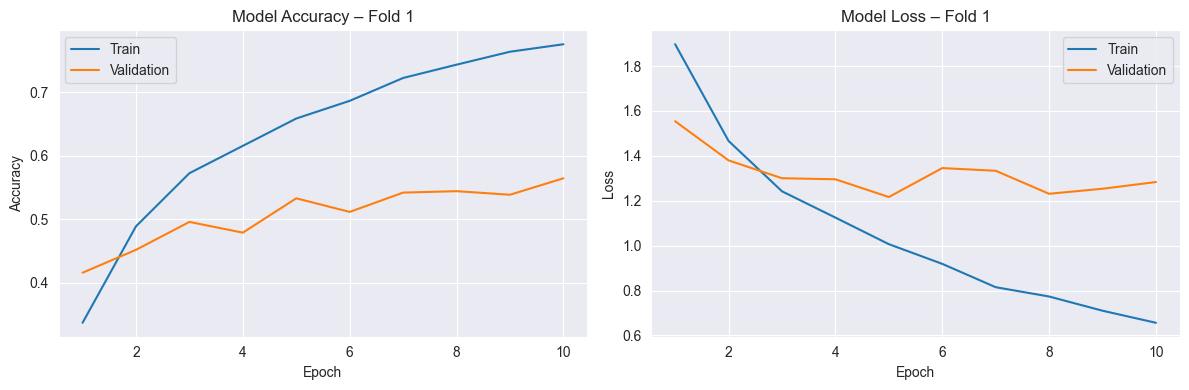

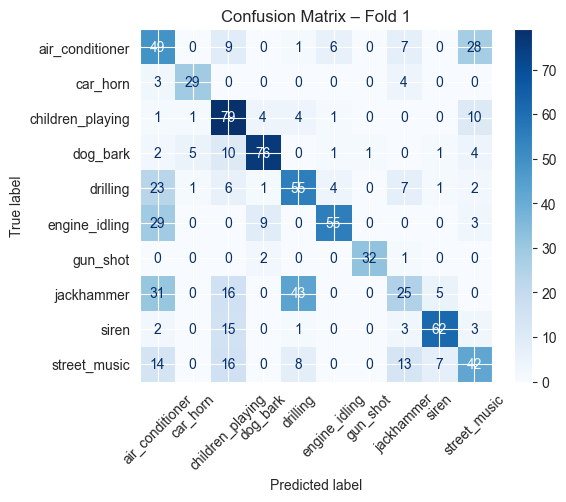


Training fold 2/10
  X_train shape: (6919, 173, 40)
  X_val   shape: (925, 173, 40)
  X_test  shape: (888, 173, 40)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
217/217 - 21s - 99ms/step - accuracy: 0.3158 - loss: 1.9451 - val_accuracy: 0.4714 - val_loss: 1.5936
Epoch 2/25
217/217 - 18s - 84ms/step - accuracy: 0.4989 - loss: 1.4605 - val_accuracy: 0.5103 - val_loss: 1.4023
Epoch 3/25
217/217 - 18s - 82ms/step - accuracy: 0.5843 - loss: 1.2370 - val_accuracy: 0.5405 - val_loss: 1.3139
Epoch 4/25
217/217 - 18s - 85ms/step - accuracy: 0.6312 - loss: 1.0962 - val_accuracy: 0.5135 - val_loss: 1.3744
Epoch 5/25
217/217 - 20s - 91ms/step - accuracy: 0.6657 - loss: 0.9753 - val_accuracy: 0.5168 - val_loss: 1.4730
Epoch 6/25
217/217 - 18s - 85ms/step - accuracy: 0.7040 - loss: 0.8914 - val_accuracy: 0.5124 - val_loss: 1.5486
Epoch 7/25
217/217 - 19s - 87ms/step - accuracy: 0.7229 - loss: 0.8106 - val_accuracy: 0.5232 - val_loss: 1.6291
Epoch 8/25
217/217 - 19s - 88ms/step - accuracy: 0.7517 - loss: 0.7434 - val_accuracy: 0.5114 - val_loss: 1.5734

Test accuracy (fold 2): 0.5180
Test loss     (fold 2): 1.3288


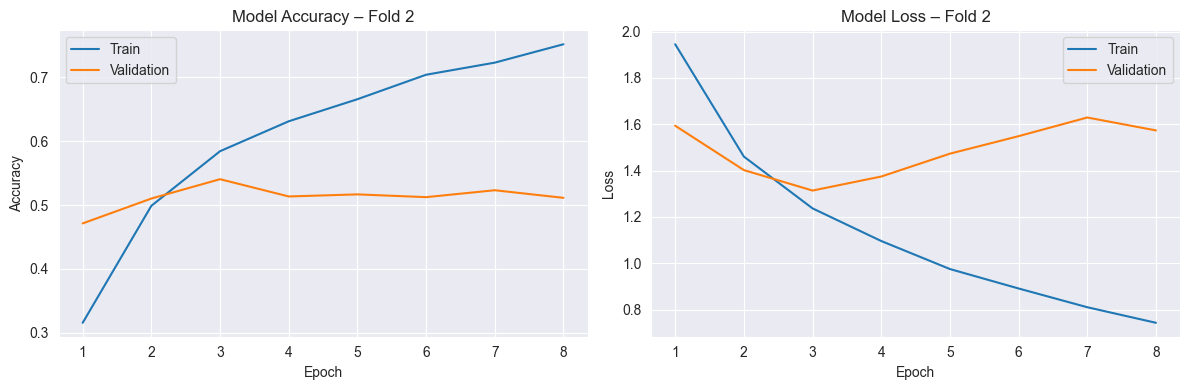

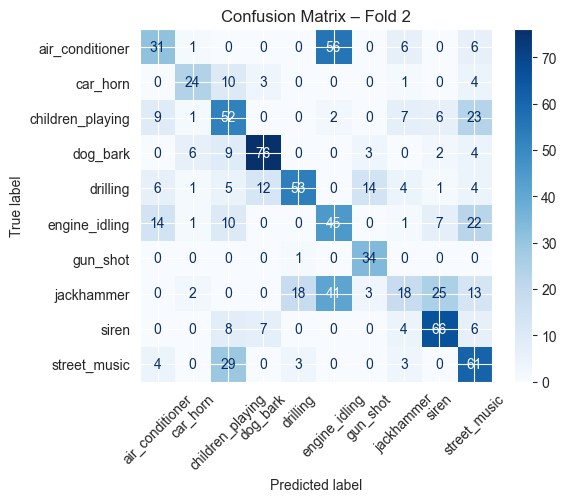


Training fold 3/10
  X_train shape: (6817, 173, 40)
  X_val   shape: (990, 173, 40)
  X_test  shape: (925, 173, 40)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
214/214 - 20s - 91ms/step - accuracy: 0.3299 - loss: 1.9362 - val_accuracy: 0.4434 - val_loss: 1.6606
Epoch 2/25
214/214 - 18s - 83ms/step - accuracy: 0.4974 - loss: 1.4302 - val_accuracy: 0.4970 - val_loss: 1.4843
Epoch 3/25
214/214 - 17s - 79ms/step - accuracy: 0.5809 - loss: 1.2236 - val_accuracy: 0.5323 - val_loss: 1.3631
Epoch 4/25
214/214 - 17s - 82ms/step - accuracy: 0.6359 - loss: 1.0614 - val_accuracy: 0.5172 - val_loss: 1.4263
Epoch 5/25
214/214 - 19s - 88ms/step - accuracy: 0.6733 - loss: 0.9613 - val_accuracy: 0.5374 - val_loss: 1.3507
Epoch 6/25
214/214 - 18s - 83ms/step - accuracy: 0.7128 - loss: 0.8387 - val_accuracy: 0.5394 - val_loss: 1.4505
Epoch 7/25
214/214 - 18s - 85ms/step - accuracy: 0.7348 - loss: 0.7685 - val_accuracy: 0.5646 - val_loss: 1.3687
Epoch 8/25
214/214 - 19s - 87ms/step - accuracy: 0.7581 - loss: 0.7129 - val_accuracy: 0.5657 - val_loss: 1.3556
Epoch 9/25
214/214 - 17s - 79ms/step - accuracy: 0.7813 - loss: 0.6655 - val_accuracy: 0.5697 - 

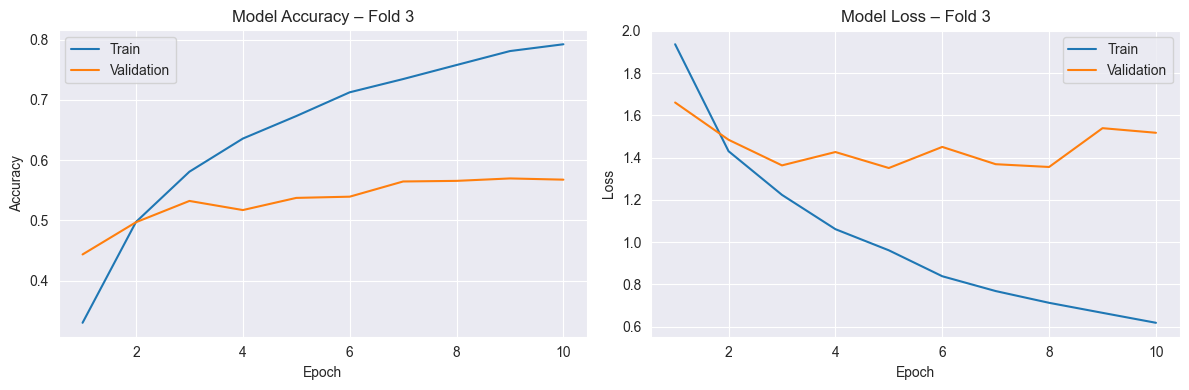

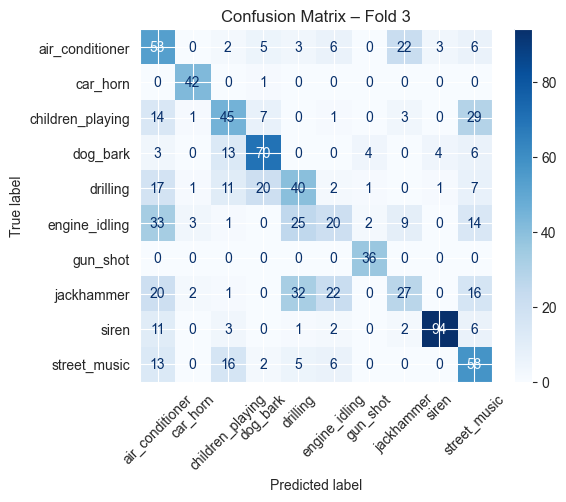


Training fold 4/10
  X_train shape: (6806, 173, 40)
  X_val   shape: (936, 173, 40)
  X_test  shape: (990, 173, 40)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
213/213 - 19s - 90ms/step - accuracy: 0.3243 - loss: 1.9087 - val_accuracy: 0.4840 - val_loss: 1.4531
Epoch 2/25
213/213 - 16s - 77ms/step - accuracy: 0.5035 - loss: 1.4055 - val_accuracy: 0.5331 - val_loss: 1.3136
Epoch 3/25
213/213 - 17s - 79ms/step - accuracy: 0.5854 - loss: 1.1964 - val_accuracy: 0.6143 - val_loss: 1.1670
Epoch 4/25
213/213 - 17s - 82ms/step - accuracy: 0.6453 - loss: 1.0397 - val_accuracy: 0.5908 - val_loss: 1.1761
Epoch 5/25
213/213 - 18s - 82ms/step - accuracy: 0.6806 - loss: 0.9311 - val_accuracy: 0.6261 - val_loss: 1.1272
Epoch 6/25
213/213 - 19s - 87ms/step - accuracy: 0.7125 - loss: 0.8394 - val_accuracy: 0.6432 - val_loss: 1.1083
Epoch 7/25
213/213 - 16s - 77ms/step - accuracy: 0.7373 - loss: 0.7512 - val_accuracy: 0.6656 - val_loss: 1.1384
Epoch 8/25
213/213 - 18s - 83ms/step - accuracy: 0.7684 - loss: 0.6807 - val_accuracy: 0.6741 - val_loss: 1.1485
Epoch 9/25
213/213 - 17s - 78ms/step - accuracy: 0.7821 - loss: 0.6342 - val_accuracy: 0.6870 - 

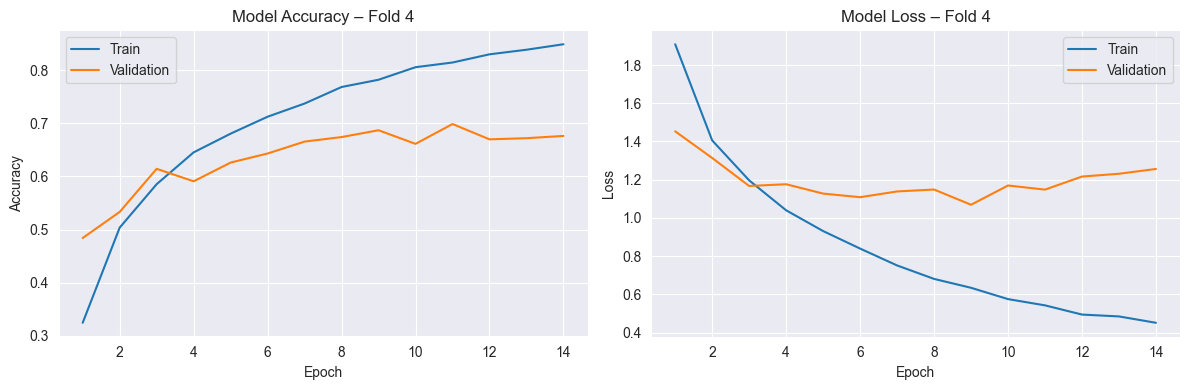

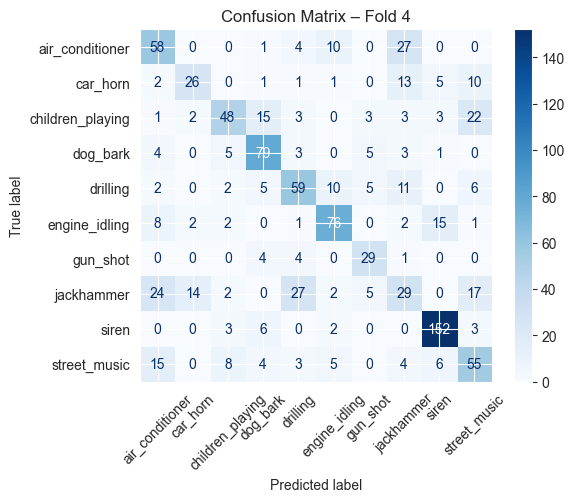


Training fold 5/10
  X_train shape: (6973, 173, 40)
  X_val   shape: (823, 173, 40)
  X_test  shape: (936, 173, 40)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
218/218 - 19s - 87ms/step - accuracy: 0.3395 - loss: 1.8853 - val_accuracy: 0.4678 - val_loss: 1.4620
Epoch 2/25
218/218 - 18s - 82ms/step - accuracy: 0.5002 - loss: 1.4459 - val_accuracy: 0.4775 - val_loss: 1.3971
Epoch 3/25
218/218 - 16s - 75ms/step - accuracy: 0.5817 - loss: 1.2194 - val_accuracy: 0.5225 - val_loss: 1.3303
Epoch 4/25
218/218 - 18s - 82ms/step - accuracy: 0.6415 - loss: 1.0638 - val_accuracy: 0.5091 - val_loss: 1.2707
Epoch 5/25
218/218 - 17s - 76ms/step - accuracy: 0.6822 - loss: 0.9310 - val_accuracy: 0.5334 - val_loss: 1.3143
Epoch 6/25
218/218 - 17s - 77ms/step - accuracy: 0.7221 - loss: 0.8416 - val_accuracy: 0.5298 - val_loss: 1.3100
Epoch 7/25
218/218 - 17s - 79ms/step - accuracy: 0.7499 - loss: 0.7518 - val_accuracy: 0.5650 - val_loss: 1.3020
Epoch 8/25
218/218 - 15s - 71ms/step - accuracy: 0.7644 - loss: 0.7000 - val_accuracy: 0.5589 - val_loss: 1.3486
Epoch 9/25
218/218 - 17s - 77ms/step - accuracy: 0.7819 - loss: 0.6593 - val_accuracy: 0.5759 - 

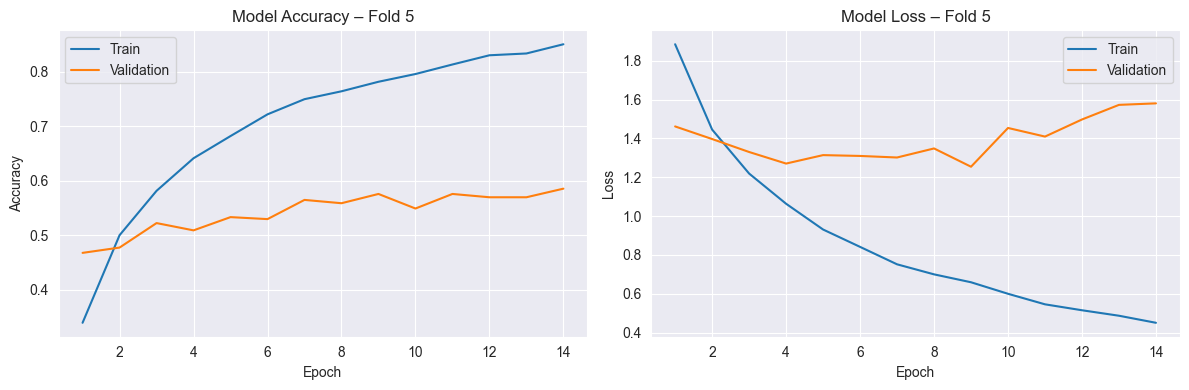

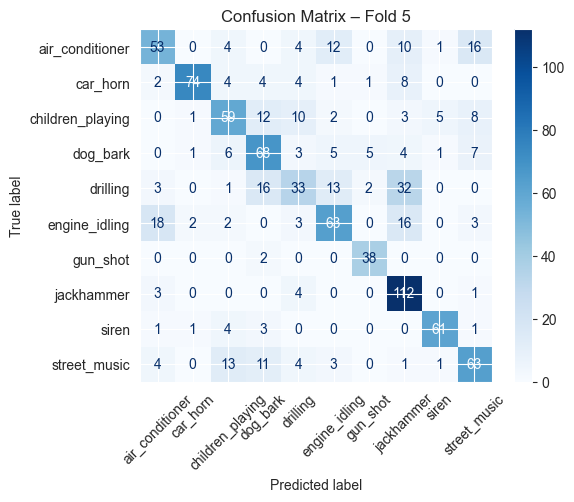


Training fold 6/10
  X_train shape: (7071, 173, 40)
  X_val   shape: (838, 173, 40)
  X_test  shape: (823, 173, 40)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
221/221 - 18s - 83ms/step - accuracy: 0.3413 - loss: 1.8896 - val_accuracy: 0.4761 - val_loss: 1.5261
Epoch 2/25
221/221 - 16s - 71ms/step - accuracy: 0.5122 - loss: 1.4021 - val_accuracy: 0.4976 - val_loss: 1.3785
Epoch 3/25
221/221 - 16s - 71ms/step - accuracy: 0.5868 - loss: 1.2127 - val_accuracy: 0.5573 - val_loss: 1.2726
Epoch 4/25
221/221 - 18s - 79ms/step - accuracy: 0.6412 - loss: 1.0528 - val_accuracy: 0.5430 - val_loss: 1.2880
Epoch 5/25
221/221 - 18s - 81ms/step - accuracy: 0.6752 - loss: 0.9552 - val_accuracy: 0.6050 - val_loss: 1.1978
Epoch 6/25
221/221 - 17s - 77ms/step - accuracy: 0.7201 - loss: 0.8426 - val_accuracy: 0.5716 - val_loss: 1.1996
Epoch 7/25
221/221 - 16s - 72ms/step - accuracy: 0.7377 - loss: 0.7960 - val_accuracy: 0.5919 - val_loss: 1.2220
Epoch 8/25
221/221 - 16s - 71ms/step - accuracy: 0.7628 - loss: 0.7060 - val_accuracy: 0.5800 - val_loss: 1.2759
Epoch 9/25
221/221 - 16s - 74ms/step - accuracy: 0.7770 - loss: 0.6598 - val_accuracy: 0.5716 - 

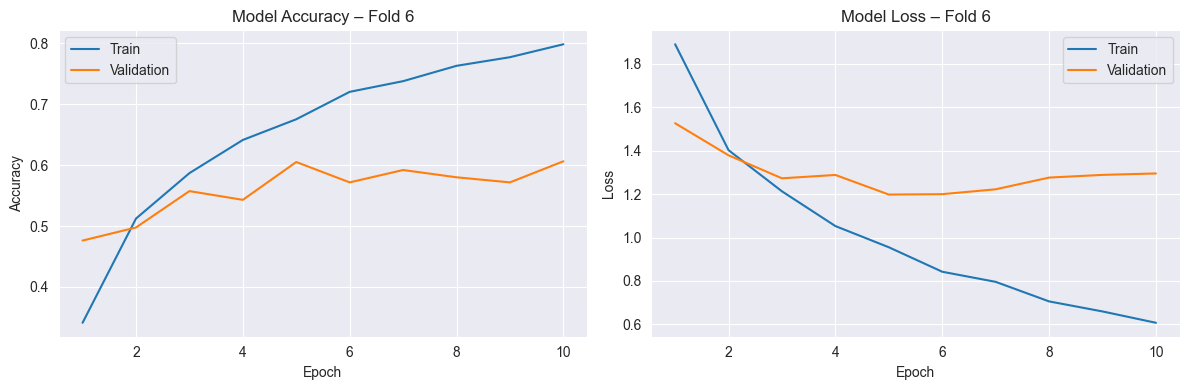

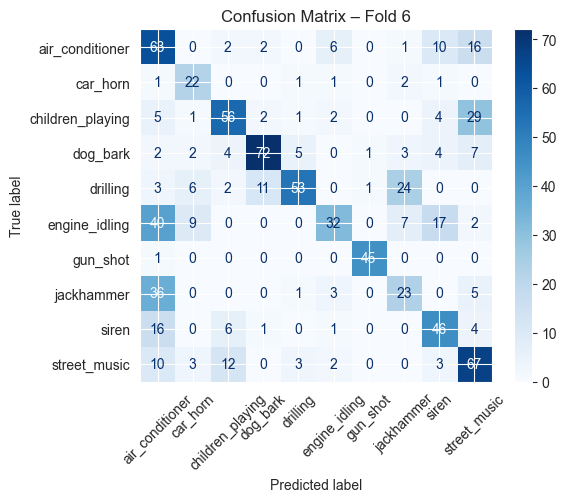


Training fold 7/10
  X_train shape: (7088, 173, 40)
  X_val   shape: (806, 173, 40)
  X_test  shape: (838, 173, 40)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
222/222 - 17s - 78ms/step - accuracy: 0.3244 - loss: 1.9416 - val_accuracy: 0.5509 - val_loss: 1.3510
Epoch 2/25
222/222 - 17s - 75ms/step - accuracy: 0.4951 - loss: 1.4664 - val_accuracy: 0.6017 - val_loss: 1.2079
Epoch 3/25
222/222 - 15s - 68ms/step - accuracy: 0.5790 - loss: 1.2551 - val_accuracy: 0.6117 - val_loss: 1.1493
Epoch 4/25
222/222 - 16s - 74ms/step - accuracy: 0.6290 - loss: 1.0924 - val_accuracy: 0.5831 - val_loss: 1.1864
Epoch 5/25
222/222 - 17s - 75ms/step - accuracy: 0.6754 - loss: 0.9640 - val_accuracy: 0.5856 - val_loss: 1.2463
Epoch 6/25
222/222 - 16s - 70ms/step - accuracy: 0.7085 - loss: 0.8577 - val_accuracy: 0.6154 - val_loss: 1.2000
Epoch 7/25
222/222 - 16s - 72ms/step - accuracy: 0.7377 - loss: 0.7757 - val_accuracy: 0.6092 - val_loss: 1.2680
Epoch 8/25
222/222 - 16s - 71ms/step - accuracy: 0.7556 - loss: 0.7322 - val_accuracy: 0.6427 - val_loss: 1.2212

Test accuracy (fold 7): 0.6098
Test loss     (fold 7): 1.1691


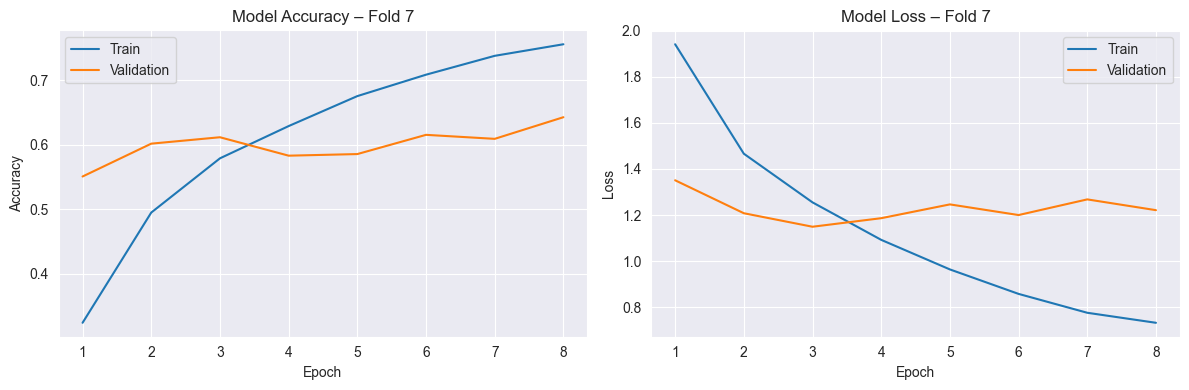

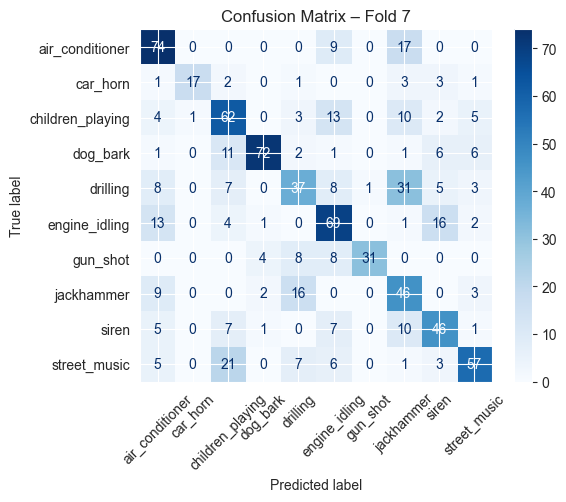


Training fold 8/10
  X_train shape: (7110, 173, 40)
  X_val   shape: (816, 173, 40)
  X_test  shape: (806, 173, 40)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
223/223 - 19s - 84ms/step - accuracy: 0.3141 - loss: 1.9558 - val_accuracy: 0.4081 - val_loss: 1.6276
Epoch 2/25
223/223 - 17s - 78ms/step - accuracy: 0.4827 - loss: 1.4888 - val_accuracy: 0.5576 - val_loss: 1.3775
Epoch 3/25
223/223 - 17s - 75ms/step - accuracy: 0.5705 - loss: 1.2555 - val_accuracy: 0.5748 - val_loss: 1.3273
Epoch 4/25
223/223 - 17s - 75ms/step - accuracy: 0.6390 - loss: 1.0794 - val_accuracy: 0.6091 - val_loss: 1.3507
Epoch 5/25
223/223 - 19s - 85ms/step - accuracy: 0.6785 - loss: 0.9593 - val_accuracy: 0.6311 - val_loss: 1.3341
Epoch 6/25
223/223 - 17s - 77ms/step - accuracy: 0.7200 - loss: 0.8393 - val_accuracy: 0.6532 - val_loss: 1.2776
Epoch 7/25
223/223 - 17s - 76ms/step - accuracy: 0.7471 - loss: 0.7598 - val_accuracy: 0.6458 - val_loss: 1.3279
Epoch 8/25
223/223 - 18s - 81ms/step - accuracy: 0.7688 - loss: 0.6927 - val_accuracy: 0.6630 - val_loss: 1.3423
Epoch 9/25
223/223 - 17s - 77ms/step - accuracy: 0.7840 - loss: 0.6386 - val_accuracy: 0.6422 - 

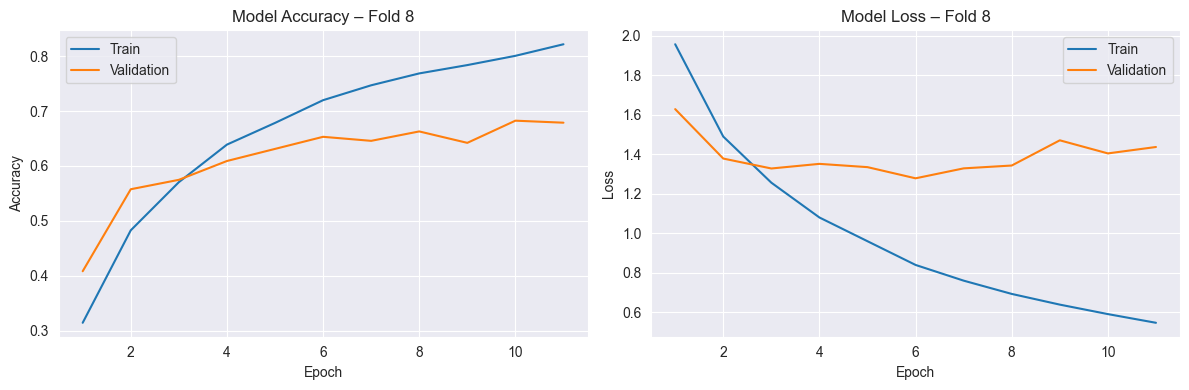

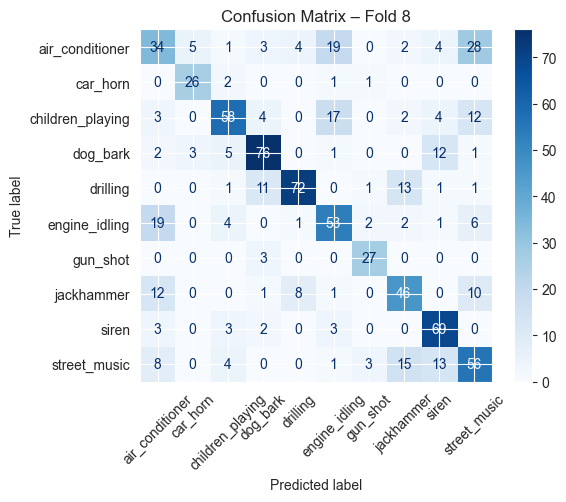


Training fold 9/10
  X_train shape: (7079, 173, 40)
  X_val   shape: (837, 173, 40)
  X_test  shape: (816, 173, 40)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
222/222 - 18s - 83ms/step - accuracy: 0.3424 - loss: 1.9035 - val_accuracy: 0.4516 - val_loss: 1.5912
Epoch 2/25
222/222 - 17s - 77ms/step - accuracy: 0.4975 - loss: 1.4492 - val_accuracy: 0.5185 - val_loss: 1.4570
Epoch 3/25
222/222 - 18s - 82ms/step - accuracy: 0.5701 - loss: 1.2392 - val_accuracy: 0.5735 - val_loss: 1.3550
Epoch 4/25
222/222 - 17s - 75ms/step - accuracy: 0.6283 - loss: 1.0946 - val_accuracy: 0.6010 - val_loss: 1.2759
Epoch 5/25
222/222 - 17s - 75ms/step - accuracy: 0.6720 - loss: 0.9652 - val_accuracy: 0.5986 - val_loss: 1.2365
Epoch 6/25
222/222 - 17s - 78ms/step - accuracy: 0.7012 - loss: 0.8852 - val_accuracy: 0.5914 - val_loss: 1.3193
Epoch 7/25
222/222 - 18s - 79ms/step - accuracy: 0.7268 - loss: 0.7974 - val_accuracy: 0.6201 - val_loss: 1.2800
Epoch 8/25
222/222 - 17s - 76ms/step - accuracy: 0.7495 - loss: 0.7359 - val_accuracy: 0.6022 - val_loss: 1.2879
Epoch 9/25
222/222 - 19s - 83ms/step - accuracy: 0.7747 - loss: 0.6739 - val_accuracy: 0.6249 - 

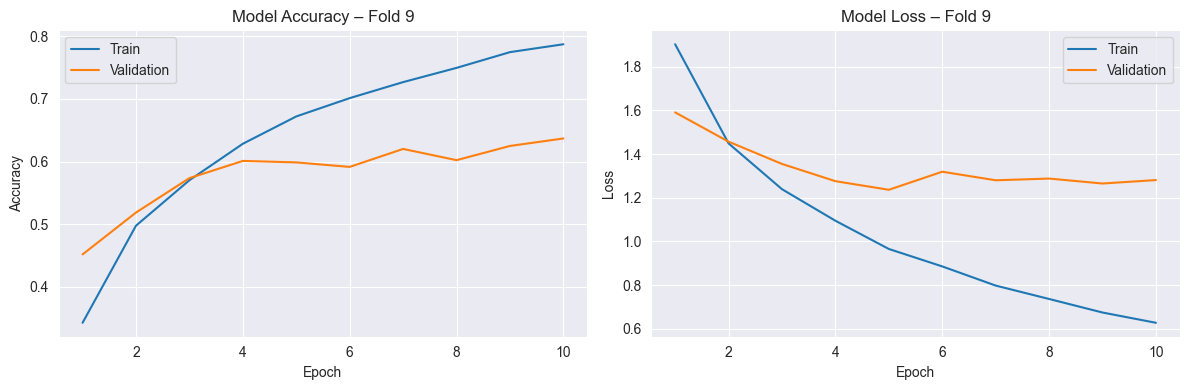


Training fold 10/10
  X_train shape: (7022, 173, 40)
  X_val   shape: (873, 173, 40)
  X_test  shape: (837, 173, 40)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ (None, 420)            │       317,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 420)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 80)             │        33,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │           810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 352,010 (1.34 MB)

 Trainable params: 352,010 (1.34 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
220/220 - 19s - 85ms/step - accuracy: 0.3362 - loss: 1.8976 - val_accuracy: 0.4777 - val_loss: 1.5240
Epoch 2/25
220/220 - 19s - 85ms/step - accuracy: 0.4980 - loss: 1.4243 - val_accuracy: 0.5086 - val_loss: 1.4056
Epoch 3/25
220/220 - 19s - 88ms/step - accuracy: 0.5809 - loss: 1.2116 - val_accuracy: 0.5384 - val_loss: 1.3639
Epoch 4/25
220/220 - 17s - 78ms/step - accuracy: 0.6307 - loss: 1.0581 - val_accuracy: 0.5510 - val_loss: 1.3321
Epoch 5/25
220/220 - 17s - 78ms/step - accuracy: 0.6736 - loss: 0.9398 - val_accuracy: 0.5567 - val_loss: 1.3490
Epoch 6/25
220/220 - 17s - 77ms/step - accuracy: 0.7156 - loss: 0.8512 - val_accuracy: 0.5762 - val_loss: 1.3223
Epoch 7/25
220/220 - 17s - 77ms/step - accuracy: 0.7365 - loss: 0.7648 - val_accuracy: 0.5785 - val_loss: 1.4193
Epoch 8/25
220/220 - 18s - 81ms/step - accuracy: 0.7647 - loss: 0.7032 - val_accuracy: 0.5773 - val_loss: 1.4772
Epoch 9/25
220/220 - 17s - 78ms/step - accuracy: 0.7791 - loss: 0.6519 - val_accuracy: 0.5647 - 



Per-fold test metrics (accuracy & loss):
Fold  1 -> test_acc = 0.5773 | test_loss = 1.2333
Fold  2 -> test_acc = 0.5180 | test_loss = 1.3288
Fold  3 -> test_acc = 0.5243 | test_loss = 1.5076
Fold  4 -> test_acc = 0.6172 | test_loss = 1.3307
Fold  5 -> test_acc = 0.6667 | test_loss = 1.0625
Fold  6 -> test_acc = 0.5820 | test_loss = 1.2842
Fold  7 -> test_acc = 0.6098 | test_loss = 1.1691
Fold  8 -> test_acc = 0.6414 | test_loss = 1.2577
Fold  9 -> test_acc = 0.5993 | test_loss = 1.2495
Fold 10 -> test_acc = 0.5902 | test_loss = 1.3088

Final 10-Fold Results (BiGRU)
-----------------------------
Mean test accuracy: 0.5926
Std  test accuracy: 0.0440
Mean test loss:     1.2732
Std  test loss:     0.1097

Accumulated Confusion Matrix (10 folds):
[[493   6  30  20  40 137   0 126  25 123]
 [ 12 309  19  10  10   8   3  34   9  15]
 [ 42   8 575  63  22  44   3  30  31 182]
 [ 26  18  86 721  17  11  20  12  33  56]
 [ 78  15  41  80 476  46  26 178  19  41]
 [198  17  24  13  31 544   5  

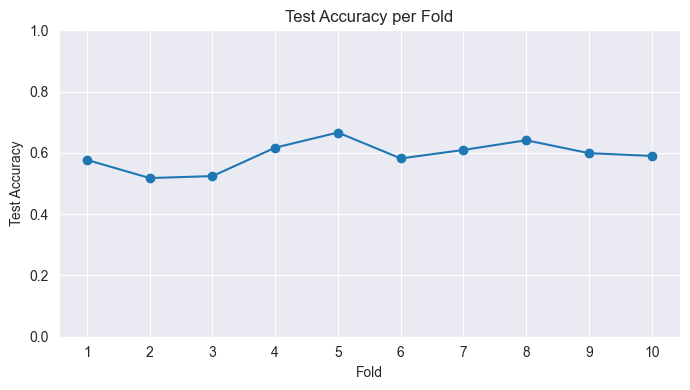

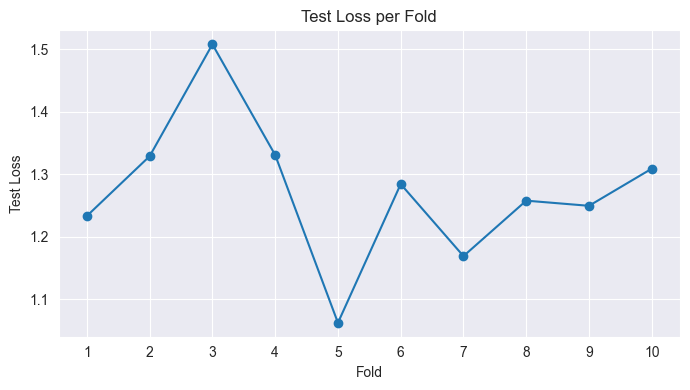

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

run_cross_validation()

### **Short Interpretation**
The BiGRU achieves stable performance (~60% accuracy), excelling on sharp acoustic events and struggling with long, noisy, low-variability classes. Confusion patterns follow expected trends for the dataset.